In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
plt.style.use('fivethirtyeight')

In [115]:
# Import Data
crime_df = pd.read_csv('data/crimes_by_hour.csv')
crime_df = crime_df.drop(crime_df.columns[0], axis=1)
print(crime_df.head())
print(crime_df.shape)
train = crime_df[0:119441]
test = crime_df[119441:]
print(train.shape)
print(test.shape)

                  Date  Count
0  2001-01-01 00:00:00    168
1  2001-01-01 01:00:00      3
2  2001-01-01 02:00:00      1
3  2001-01-01 03:00:00      1
4  2001-01-01 07:00:00      2
(149302, 2)
(119441, 2)
(29861, 2)


Date
2001      3852
2002    345012
2003    471992
2004    467128
2005    449870
2006    445494
2007    435527
2008    419783
2009    385830
2010    369786
2011    350890
2012    335066
2013    306289
2014    273574
2015    257750
2016    266450
2017    264193
2018    226358
Name: Count, dtype: int64
[  3852 345012 471992 467128 449870 445494 435527 419783 385830 369786
 350890 335066 306289 273574 257750 266450 264193 226358]
Int64Index([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
            2012, 2013, 2014, 2015, 2016, 2017, 2018],
           dtype='int64', name='Date')


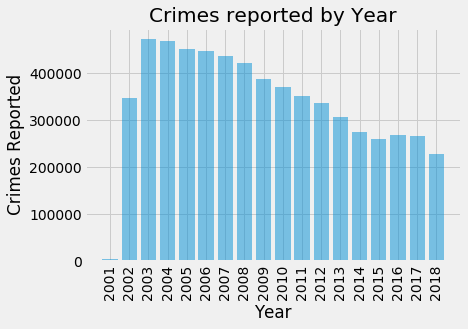

In [116]:
year_counts = crime_df.groupby([pd.to_datetime(crime_df['Date']).dt.year])['Count'].sum()
year_counts_df = year_counts.to_frame()
print(year_counts)

years = year_counts.index
values = year_counts.values
print(values)
print(years)
y_pos = np.arange(len(years))
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, years)
plt.ylabel('Crimes Reported')
plt.xlabel('Year')
plt.title('Crimes reported by Year')
plt.xticks(rotation=90)
plt.show()



In [117]:
# Create Indexes

train = train.set_index(pd.DatetimeIndex(train['Date']))
test = test.set_index(pd.DatetimeIndex(test['Date']))

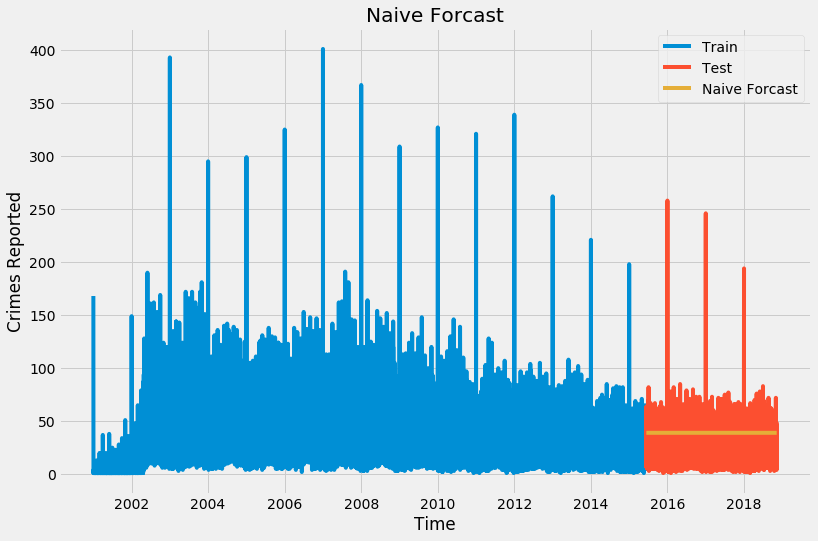

15.628775756917904


In [118]:
# Naive
dd = np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd) - 1]

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forcast')
plt.legend(loc='best')
plt.title('Naive Forcast')
plt.xlabel('Time')
plt.ylabel('Crimes Reported')
plt.show()

naive_rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(naive_rms)

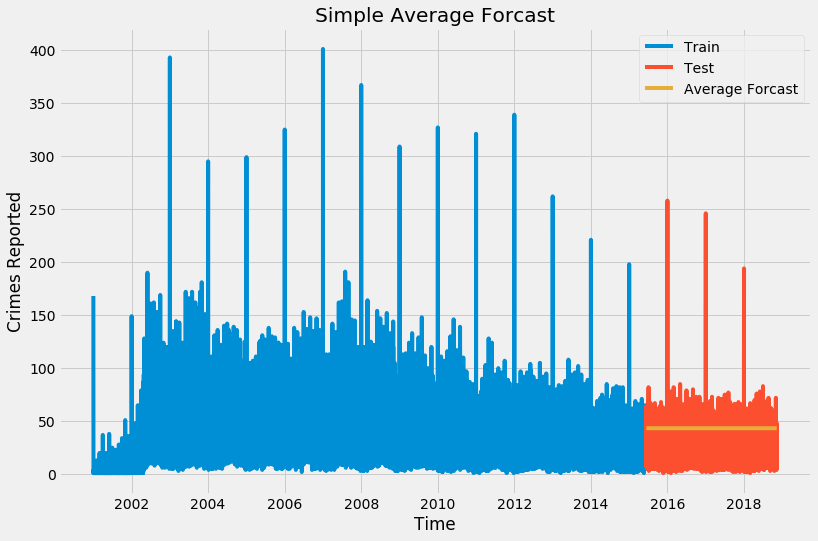

18.390152552300616


In [119]:
# Simple Average

y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'].mean()

plt.figure(figsize=(12, 8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forcast')
plt.legend(loc='best')
plt.title('Simple Average Forcast')
plt.xlabel('Time')
plt.ylabel('Crimes Reported')
plt.show()

average_rms = sqrt(mean_squared_error(test.Count, y_hat_avg.avg_forecast))
print(average_rms)

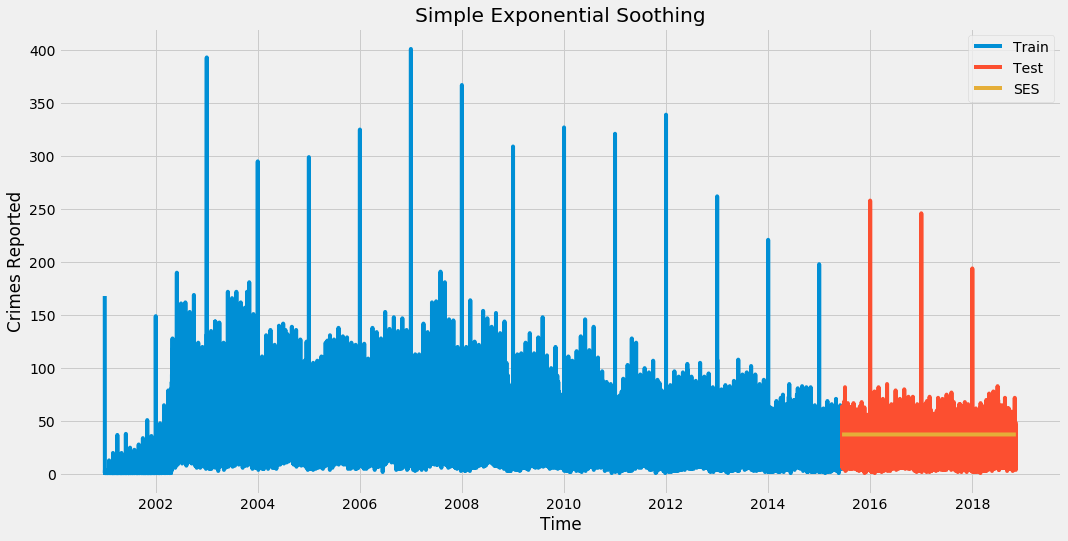

14.804502366608618


In [120]:
# Simple Exponential Soothing

y_hat_avg_ses = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6)
y_hat_avg_ses['SES'] = fit2.forecast(len(test))

plt.figure(figsize=(16, 8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg_ses['SES'], label='SES')
plt.title('Simple Exponential Soothing')
plt.xlabel('Time')
plt.ylabel('Crimes Reported')
plt.legend(loc='best')
plt.show()

ses_rms = sqrt(mean_squared_error(test.Count, y_hat_avg_ses.SES))
print(ses_rms)


In [140]:
# Extracting Features

train_copy = train.copy()
test_copy = test.copy()

for i in (train, test, train_copy, test_copy):
    i['Year'] = i.index.year
    i['Month'] = i.index.month
    i['Day'] = i.index.day
    i['Hour'] = i.index.hour
    
train_copy['DOW'] = train_copy.index.dayofweek
temp = train_copy.index

def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0


temp2 = train_copy.index.to_series().apply(lambda x: applyer(x))
train_copy['Weekend'] = temp2
print(train_copy.head())

                                    Date  Count  Year  Month  Day  Hour  DOW  \
Date                                                                           
2001-01-01 00:00:00  2001-01-01 00:00:00    168  2001      1    1     0    0   
2001-01-01 01:00:00  2001-01-01 01:00:00      3  2001      1    1     1    0   
2001-01-01 02:00:00  2001-01-01 02:00:00      1  2001      1    1     2    0   
2001-01-01 03:00:00  2001-01-01 03:00:00      1  2001      1    1     3    0   
2001-01-01 07:00:00  2001-01-01 07:00:00      2  2001      1    1     7    0   

                     Weekend  
Date                          
2001-01-01 00:00:00        0  
2001-01-01 01:00:00        0  
2001-01-01 02:00:00        0  
2001-01-01 03:00:00        0  
2001-01-01 07:00:00        0  


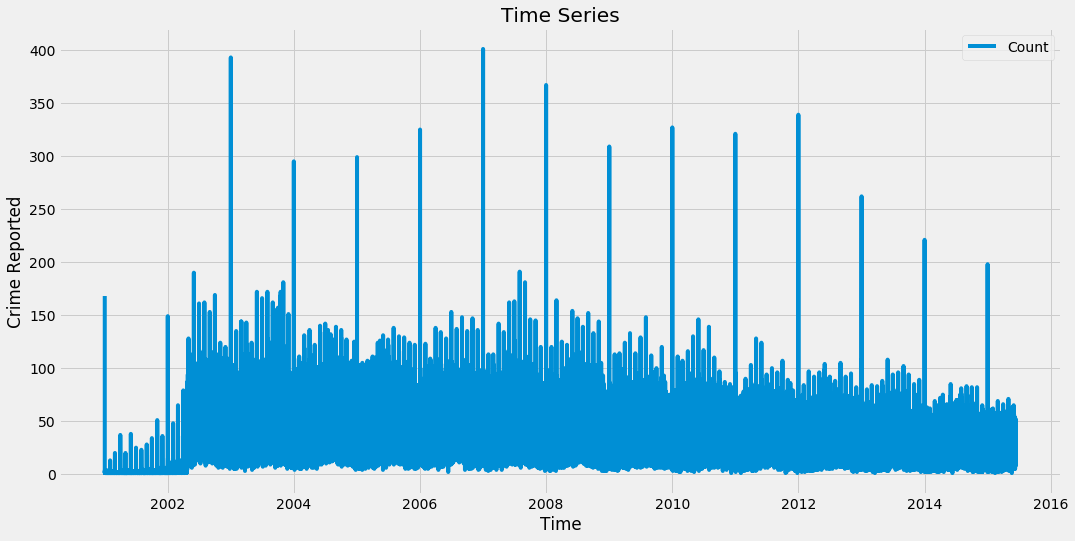

In [141]:
ts = train_copy['Count']
plt.figure(figsize=(16, 8))
plt.plot(ts)
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Crime Reported')
plt.legend(loc='best')
plt.show()

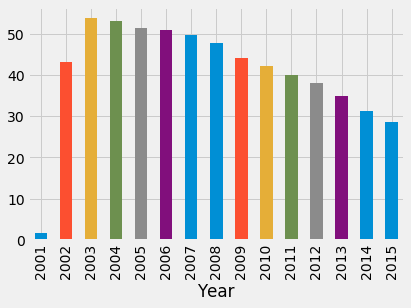

In [142]:
train_copy.groupby('Year')['Count'].mean().plot.bar()

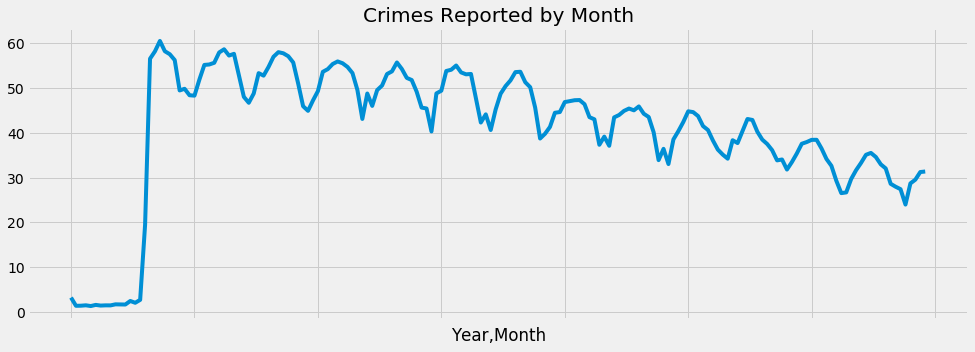

In [143]:
temp = train.groupby(['Year', 'Month'])['Count'].mean()
temp.plot(figsize=(15, 5), title='Crimes Reported by Month', fontsize=14)

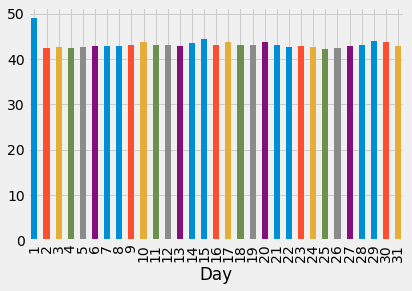

In [144]:
train_copy.groupby('Day')['Count'].mean().plot.bar()

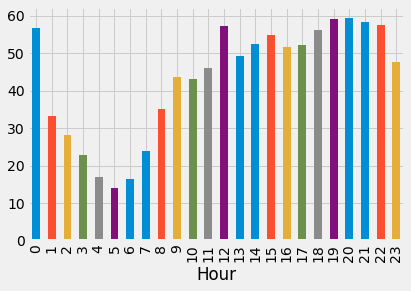

In [145]:
train_copy.groupby('Hour')['Count'].mean().plot.bar()

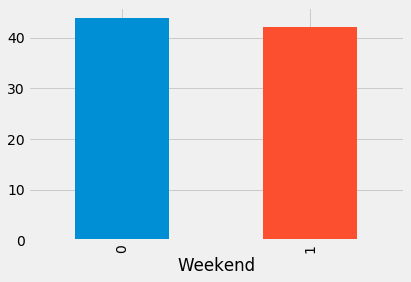

In [146]:
train_copy.groupby('Weekend')['Count'].mean().plot.bar()

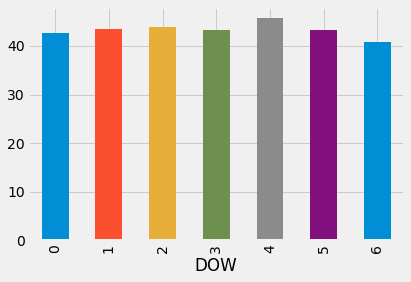

In [92]:
train_copy.groupby('DOW')['Count'].mean().plot.bar()

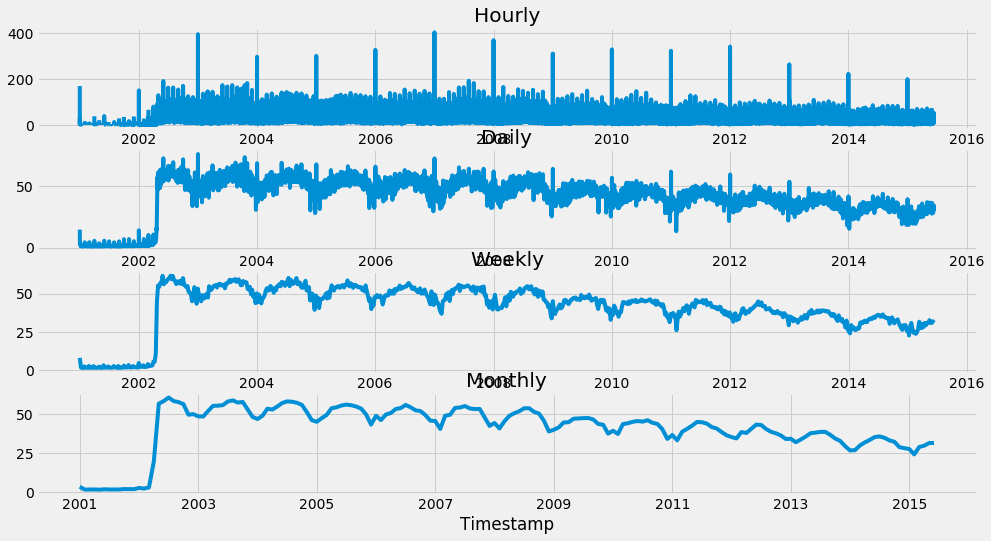

In [152]:
train_copy['Timestamp'] = pd.to_datetime(train_copy.index, format='%d-%m-%y %H:%M')
train_copy.index = train_copy['Timestamp']

hourly = train_copy.resample('H').mean()
daily = train_copy.resample('D').mean()
weekly = train_copy.resample('W').mean()
monthly = train_copy.resample('M').mean()

fig,axs = plt.subplots(4,1)

hourly.Count.plot(figsize = (15,8), title = "Hourly", fontsize = 14, ax = axs[0])
daily.Count.plot(figsize = (15,8), title = "Daily", fontsize = 14, ax = axs[1])
weekly.Count.plot(figsize = (15,8), title = "Weekly", fontsize = 14, ax = axs[2])
monthly.Count.plot(figsize = (15,8), title = "Monthly", fontsize = 14, ax = axs[3])